# Bike theft analysis

My bike was stolen in fall 2016 in Berkeley. I decided to try to figure out why. Fortunately, the [Bike Index](https://www.bikeindex.org) makes all of their data on reported bike thefts publicly available through their API.

In [2]:
import requests
import json
import unicodecsv as csv
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [ ]:
start = 1262419199 #Epoch timestamp for 1/1/2010
end = 1451635199 #Epoch timestamp for 12/31/2015
proximity = 'San Francisco, CA'
proximity_square = 20

url = """https://bikeindex.org:443/api/v2/bikes_search/stolen?page={0}&per_page=25&proximity=San%20Francisco%2C%20CA&proximity_square=20&stolen_before=1451635199&stolen_after=1262419199"""

r = requests.get('https://bikeindex.org:443/api/v2/bikes_search/stolen?proximity=San%20Francisco%2C%20CA&proximity_square=20&stolen_before=1451635199&stolen_after=1262419199')
per_page = 25;
num_bikes = int(r.headers['Total'])
num_pages = int(math.ceil(num_bikes/per_page))

for i in range(num_pages + 1):
   url_page = url.format(i+1)
   r = requests.get(url_page.format(i))
   j = r.json()
   with open('./api-output/{0}.json'.format(i), 'w') as outfile:
       json.dump(j, outfile)

writer = csv.writer(open('bike-data.csv', 'wb+'), dialect='excel', encoding='utf-8')

def convert_time(timestamp):
    value = datetime.datetime.fromtimestamp(timestamp)
    val = value.strftime('%Y-%m-%d')
    return val.encode('utf-8')

writer.writerow(['id', 'title', 'serial', 'manufacturer_name', 'frame_model', 'year', 'frame_colors', 'stolen', 'stolen_location', 'date_stolen'])

for i in range(145):
    json_file = open('./api-output/{0}.json'.format(i), "r")
    x = json.load(json_file)
    bikes = x['bikes']
    for b in bikes:
        writer.writerow([
            b['id'],
            b['title'],
            b['serial'],
            b['manufacturer_name'],
            b['frame_model'],
            b['year'],
            b['frame_colors'],
            b['stolen'],
            b['stolen_location'], 
            b['date_stolen']
        ])

Now, to plot the data:

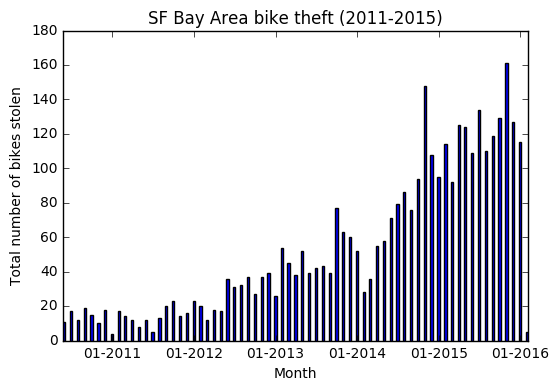

In [4]:
b_data = pd.read_csv("bike-data.csv", header=0)
b_data['date_stolen'] = pd.to_datetime(b_data['date_stolen'], utc=True, unit='s')
b_data = b_data.set_index('date_stolen')

monthly = pd.groupby(b_data, pd.TimeGrouper(freq='M')).count()
monthly = b_data.resample('M').count()

fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.bar(monthly.index, monthly['id'], width=10, align='center')
plt.xlabel("Month")
plt.ylabel("Total number of bikes stolen")
plt.title("SF Bay Area bike theft (2011-2015)")
locs, labels = plt.xticks()
# plt.setp(labels, rotation=40)
plt.savefig("monthly_total_thefts")
plt.show()

Not that revealing. Bike Index has only been around since the late 2000s. This probably does a better job of revealing the Bike Index adoption curve than the actual underlying frequency with which bikes are stolen. Let's fix that by normalizing the data by year.

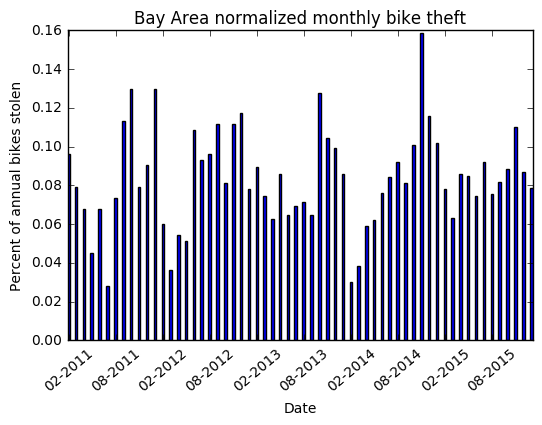

In [5]:
# Get rid of incomplete years (2010 and 2016)
monthly = monthly.ix['2011-01-01':'2015-12-31']

months = np.arange(12) + 1
years = ['2011', '2012', '2013', '2014', '2015']

for year in years:
    yearly_sum = monthly[year]['id'].sum()
    monthly[year] = monthly[year] / yearly_sum
    
fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.bar(monthly.index, monthly['id'], width=10, align='center')
locs, labels = plt.xticks()
plt.setp(labels, rotation=40)
plt.xlabel("Date")
plt.ylabel("Percent of annual bikes stolen")
plt.title("Bay Area normalized monthly bike theft")
plt.savefig("monthly_normalized_thefts.png")
plt.show()

Better! Would be more insightful to see the data as an average over each month.

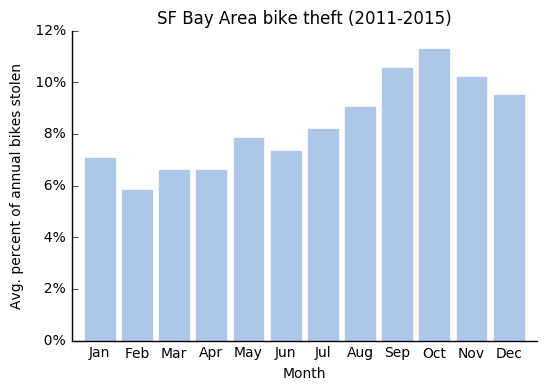

In [6]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 10

# Thanks to Tableau for these colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

def get_average_theft_freq(month, series):
    running_total = 0
    years = [2011, 2012, 2013, 2014, 2015]
    for year in years:
        running_total += float(series['{0}-{1}'.format(month, year)]['id'])
    return running_total/5
    
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
theft_freq = [get_average_theft_freq(month, monthly) for month in months]

fig, ax = plt.subplots()

barlist = plt.bar(range(12), theft_freq, align='center')
plt.xticks(range(12), months)
locs, labels = plt.xticks()
ax.margins(0.03, None)
plt.xlabel("Month")
plt.ylabel("Avg. percent of annual bikes stolen")
plt.title("SF Bay Area bike theft (2011-2015)")

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    

ax.get_yaxis().tick_left()

plt.tick_params(axis='x', which='both', bottom='off', top='off')

for bar in barlist:
    bar.set_color(tableau20[1])
plt.savefig("monthly_normalized_thefts_aggregated.png")
plt.show()